# 002_Modelling

In [1]:
from collections import Counter
from numpy import unique
from numpy import mean
from numpy import std
from pandas import read_pickle
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from category_encoders.woe import WOEEncoder
from imblearn.over_sampling import SMOTENC

# Pipeline
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

/Users/rory.hurley/Documents/GitHub/uscb_classifier/usbc_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processed = pd.read_csv("../data/featurised/featurised_train.csv")

In [3]:
processed.head(2)

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,dividends from stocks,citizenship,own business or self employed,weeks worked in year,wage per hour,income
0,73,3,2,3,14,6,4,0,0,0,0,1,0,0,0,0
1,58,6,3,0,4,8,4,1,0,0,0,1,0,52,0,0


In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

df1 = processed.copy()
df1 = df1.apply(LabelEncoder().fit_transform)
df1.head()


,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,dividends from stocks,citizenship,own business or self employed,weeks worked in year,wage per hour,income
0,73,3,2,3,14,6,4,0,0,0,0,1,0,0,0,0
1,58,6,3,0,4,8,4,1,0,0,0,1,0,52,0,0
2,18,3,5,1,14,6,1,0,0,0,0,0,0,0,0,0
3,9,3,5,1,14,6,4,0,0,0,0,1,0,0,0,0
4,10,3,5,1,14,6,4,0,0,0,0,1,0,0,0,0


### Dummy Classifier

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#establishing random_state for reproducibility
clf_dummy = DummyClassifier(random_state=42) 

X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf_dummy.fit(X_train, y_train)

print(clf_dummy.score(X_train, y_train))

y_pred = clf_dummy.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['O', '1']))

0.9195549920242136
              precision    recall  f1-score   support

           O       0.92      1.00      0.96     28076
           1       0.00      0.00      0.00      2486

    accuracy                           0.92     30562
   macro avg       0.46      0.50      0.48     30562
weighted avg       0.84      0.92      0.88     30562



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Model Selection

In [ ]:
# Config
from sklearn import set_config
set_config(display='diagram')

# Evaluate model
def evaluate_model(X, y, model):
    """
    *Reference sklearn.metrics.SCORERS.keys() for list of available scorers*
    """
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=143)
    # Evaluate model
    scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=4)
    return scores

# Models dictionary
def get_models():
    models_dict = {
        'LogReg': LogisticRegression(max_iter=10000, n_jobs=-1),
        'RF': RandomForestClassifier(n_estimators=1000),
        'XGB': XGBClassifier(n_estimators=1000),
        'KNN': KNeighborsClassifier(n_jobs=-1)
    }
    
    return models_dict

In [44]:
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [45]:
# Define models
models = get_models()

# Evaluate models
results = {}

for k, v in models.items():
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', v)
    ])
    
    # Evaluate model
    scores = evaluate_model(X_train, y_train, clf)
    results[k] = scores
    name = k
    print(f"{name}\n{'-' * len(name)}")
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
    print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
    print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
    print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
    print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

LogReg
------
Mean Accuracy: 0.931 (0.002)
Mean F1: 0.362 (0.024)
Mean Recall: 0.249 (0.020)
Test Precision: 0.663 (0.034)
Mean ROC-AUC: 0.885 (0.007)



A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


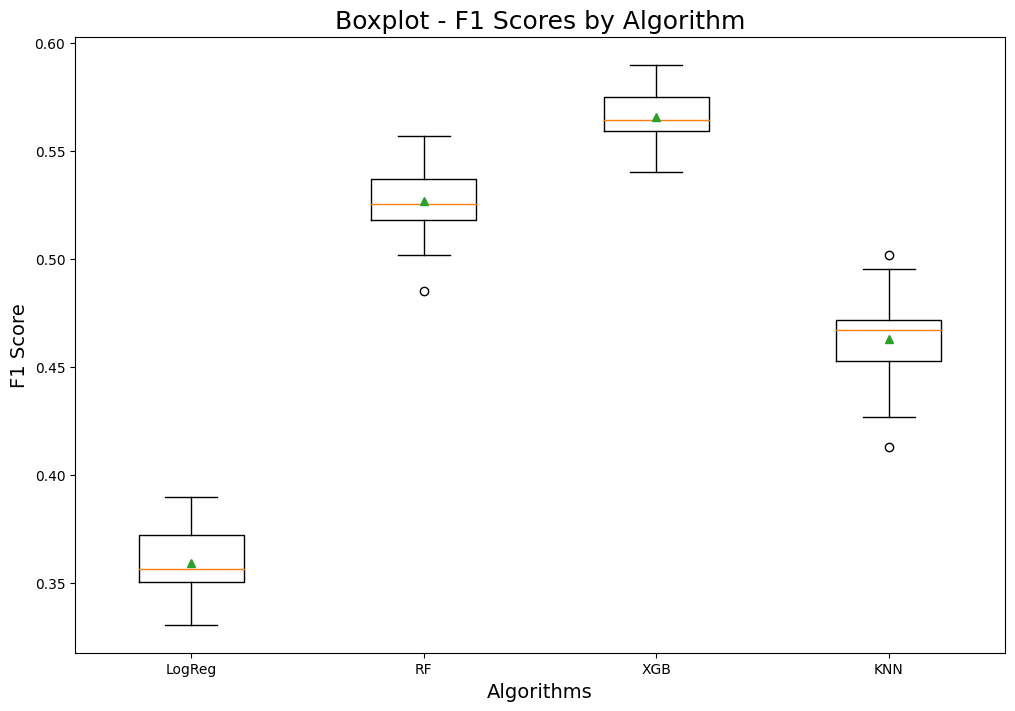

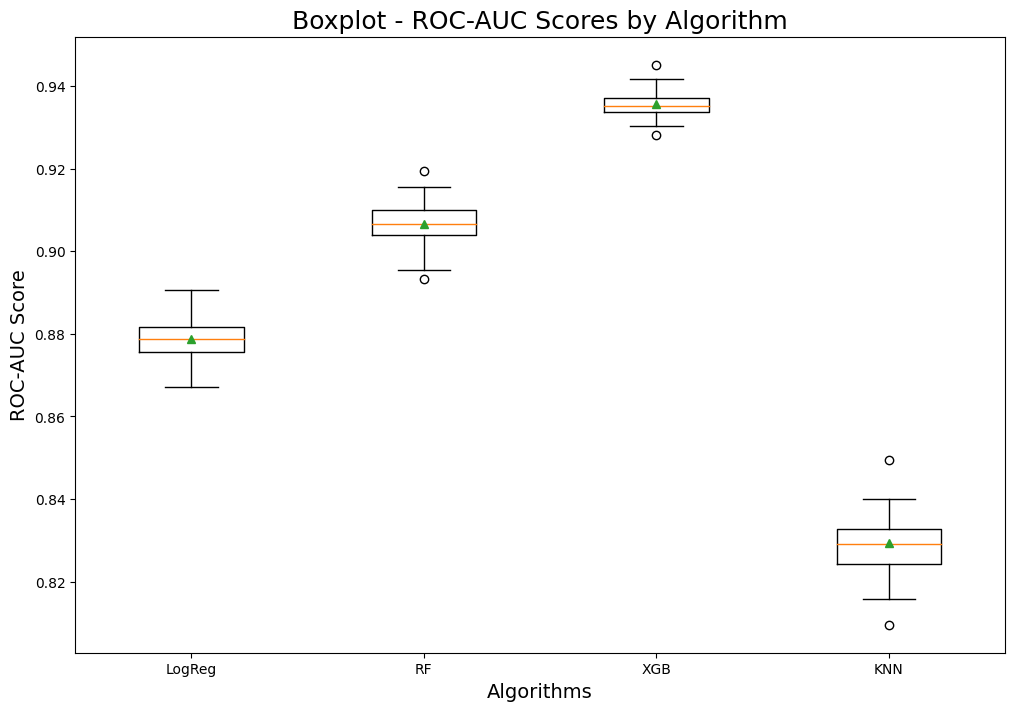

In [ ]:
# Prepare plot inputs
names = []
f1 = []
roc_auc = []

for k, v in results.items():
    names.append(k)
    f1.append(v['test_f1'])
    roc_auc.append(v['test_roc_auc'])
    
# F1 scores    
fig = plt.figure(figsize=(12, 8))
plt.boxplot(f1, labels=names, showmeans=True)
plt.title("Boxplot - F1 Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
print("")
plt.show();

# ROC-AUC scores
fig = plt.figure(figsize=(12, 8))
plt.boxplot(roc_auc, labels=names, showmeans=True)
plt.title("Boxplot - ROC-AUC Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
print("" * 2)
plt.show();

XGBoost Appears to be the performant algorithm.

## SMOTE

Now assess if using SMOTE to balance datasets improves performance...

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 140487, 1: 12320})


In [ ]:
sm = SMOTE(random_state=42)

In [ ]:
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140487, 1: 140487})


In [ ]:
X_res

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,dividends from stocks,citizenship,own business or self employed,weeks worked in year,wage per hour
0,73,3,2,3,14,6,4,0,0,0,0,1,0,0,0
1,58,6,3,0,4,8,4,1,0,0,0,1,0,52,0
2,18,3,5,1,14,6,1,0,0,0,0,0,0,0,0
3,9,3,5,1,14,6,4,0,0,0,0,1,0,0,0
4,10,3,5,1,14,6,4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280969,54,4,1,4,14,11,4,1,0,54,151,1,0,52,0
280970,38,1,6,2,9,10,1,0,0,0,0,0,1,52,1075
280971,51,1,1,1,4,9,4,0,117,0,0,1,0,40,0
280972,43,1,1,1,18,10,4,1,0,0,1181,1,0,52,0


In [ ]:
# Define models
models = get_models()

# Evaluate models
results = {}

for k, v in models.items():
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', v)
    ])
    
    # Evaluate model
    scores = evaluate_model(X_res, y_res, clf)
    results[k] = scores
    name = k
    print(f"{name}\n{'-' * len(name)}")
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
    print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
    print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
    print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
    print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

LogReg
------
Mean Accuracy: 0.786 (0.002)
Mean F1: 0.794 (0.002)
Mean Recall: 0.826 (0.003)
Test Precision: 0.764 (0.003)
Mean ROC-AUC: 0.871 (0.002)



A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RF
--
Mean Accuracy: 0.944 (0.002)
Mean F1: 0.945 (0.002)
Mean Recall: 0.963 (0.002)
Test Precision: 0.928 (0.002)
Mean ROC-AUC: 0.984 (0.001)

XGB
---
Mean Accuracy: 0.900 (0.002)
Mean F1: 0.901 (0.002)
Mean Recall: 0.911 (0.002)
Test Precision: 0.892 (0.002)
Mean ROC-AUC: 0.966 (0.001)

KNN
---
Mean Accuracy: 0.904 (0.002)
Mean F1: 0.907 (0.002)
Mean Recall: 0.937 (0.002)
Test Precision: 0.879 (0.003)
Mean ROC-AUC: 0.955 (0.001)



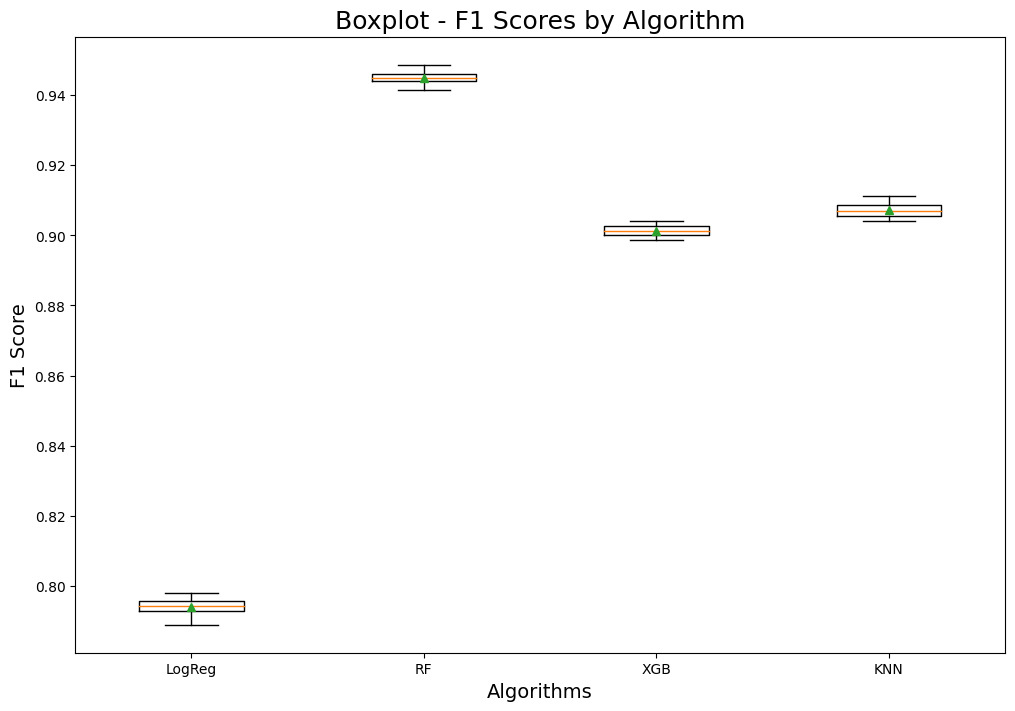

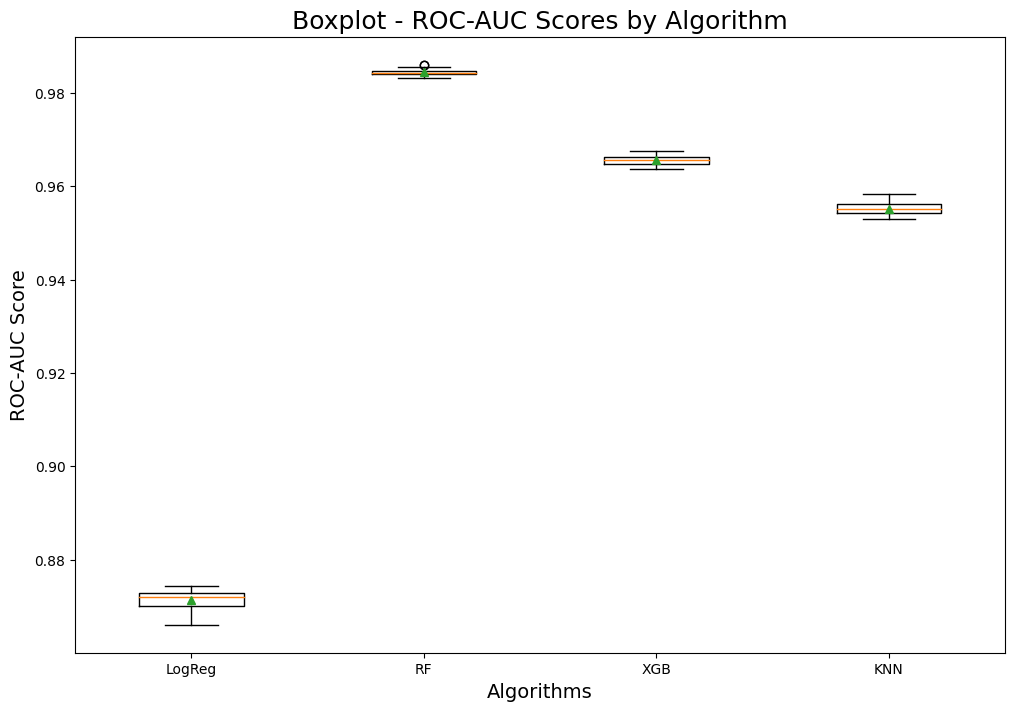

In [ ]:
# Prepare plot inputs
names = []
f1 = []
roc_auc = []

for k, v in results.items():
    names.append(k)
    f1.append(v['test_f1'])
    roc_auc.append(v['test_roc_auc'])
    
# F1 scores    
fig = plt.figure(figsize=(12, 8))
plt.boxplot(f1, labels=names, showmeans=True)
plt.title("Boxplot - F1 Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
print("")
plt.show();

# ROC-AUC scores
fig = plt.figure(figsize=(12, 8))
plt.boxplot(roc_auc, labels=names, showmeans=True)
plt.title("Boxplot - ROC-AUC Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
print("" * 2)
plt.show();

In [ ]:
filename = "../models/smote_xgboost.pkl"
pickle.dump(pipe_xgb, open(filename, 'wb'))

## Predict on Test Data

In [25]:
test = pd.read_csv("../data/featurised/featurised_test.csv")

In [27]:
test_copy = test.copy()
test_copy = test_copy.apply(LabelEncoder().fit_transform)
test_copy.head()

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,dividends from stocks,citizenship,own business or self employed,weeks worked in year,wage per hour,income
0,38,4,5,4,10,5,4,0,0,0,0,0,0,12,0,0
1,44,6,3,4,2,10,4,0,0,0,780,1,0,26,0,0
2,2,3,5,1,14,6,4,1,0,0,0,1,0,0,0,0
3,35,4,2,0,21,2,4,0,0,0,0,1,2,52,0,0
4,49,4,2,0,4,8,4,1,0,0,0,1,0,50,0,0


In [28]:
X_test = test_copy.iloc[:, :-1]
y_test = test_copy.iloc[:, -1]

In [29]:
clf = RandomForestClassifier(n_estimators=100)
scores = evaluate_model(X_res, y_res, clf)

In [31]:
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

Mean Accuracy: 0.944 (0.002)
Mean F1: 0.945 (0.002)
Mean Recall: 0.963 (0.002)
Test Precision: 0.928 (0.002)
Mean ROC-AUC: 0.984 (0.001)



In [40]:
clf = XGBClassifier(n_estimators=100)
clf.fit(X_res, y=y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [41]:
y_pred = clf.predict(X_test)

In [42]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     72662
           1       0.38      0.73      0.50      6164

    accuracy                           0.89     78826
   macro avg       0.68      0.81      0.72     78826
weighted avg       0.93      0.89      0.90     78826

